#### lasso + AIC 

In [1]:
# from cuml import LogisticRegression, Lasso, Ridge, ElasticNet

In [7]:
import time

from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True, as_frame=True)
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [8]:
import numpy as np
import pandas as pd

rng = np.random.RandomState(42)
n_random_features = 14
X_random = pd.DataFrame(
    rng.randn(X.shape[0], n_random_features),
    columns=[f"random_{i:02d}" for i in range(n_random_features)],
)
X = pd.concat([X, X_random], axis=1)
# Show only a subset of the columns
X[X.columns[::3]].head()

,age,bp,s3,s6,random_02,random_05,random_08,random_11
0,0.038076,0.021872,-0.043401,-0.017646,0.647689,-0.234137,-0.469474,-0.465730
1,-0.001882,-0.026328,0.074412,-0.092204,-1.012831,-1.412304,0.067528,0.110923
2,0.085299,-0.005670,-0.032356,-0.025930,-0.601707,-1.057711,0.208864,0.196861
3,-0.089063,-0.036656,-0.036038,-0.009362,-1.478522,1.057122,0.324084,0.611676
4,0.005383,0.021872,0.008142,-0.046641,0.331263,-0.185659,0.812526,1.003533


In [9]:
start_time = time.time()
lasso_lars_ic = make_pipeline(StandardScaler(), LassoLarsIC(criterion="aic")).fit(X, y)
fit_time = time.time() - start_time

results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "AIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")
alpha_aic = lasso_lars_ic[-1].alpha_

In [11]:
from cuml import LogisticRegression, Lasso, Ridge, ElasticNet

make_pipeline(StandardScaler(), Lasso())

Pipeline(steps=[('standardscaler', StandardScaler()), ('lasso', Lasso())])

In [12]:
lasso_lars_ic

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lassolarsic', LassoLarsIC())])

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

for tol in [-1e-2, -1e-3, -1e-4]:
    start = time()
    feature_selector = SequentialFeatureSelector(
        LogisticRegression(),
        n_features_to_select="auto",
        direction="backward",
        scoring="roc_auc",
        tol=tol,
        n_jobs=2,
    )
    model = make_pipeline(StandardScaler(), feature_selector, LogisticRegression())
    model.fit(X, y)
    end = time()
    print(f"\ntol: {tol}")
    print(f"Features selected: {feature_names[model[1].get_support()]}")
    print(f"ROC AUC score: {roc_auc_score(y, model.predict_proba(X)[:, 1]):.3f}")
    print(f"Done in {end - start:.3f}s")

TypeError: 'module' object is not callable

## SFS 

In [14]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

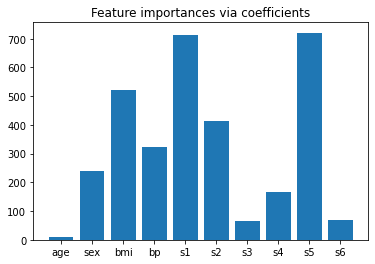

In [15]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X, y)
importance = np.abs(ridge.coef_)
feature_names = np.array(diabetes.feature_names)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

In [16]:
from time import time

from sklearn.feature_selection import SelectFromModel

threshold = np.sort(importance)[-3] + 0.01

tic = time()
sfm = SelectFromModel(ridge, threshold=threshold).fit(X, y)
toc = time()
print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")
print(f"Done in {toc - tic:.3f}s")

Features selected by SelectFromModel: ['s1' 's5']
Done in 0.001s


In [17]:
from sklearn.feature_selection import SequentialFeatureSelector

tic_fwd = time()
sfs_forward = SequentialFeatureSelector(
    ridge, n_features_to_select=2, direction="forward"
).fit(X, y)
toc_fwd = time()

tic_bwd = time()
sfs_backward = SequentialFeatureSelector(
    ridge,
    n_features_to_select=2,
    direction="backward",
    cv=5,
    scoring="neg_mean_squared_error",
).fit(X, y)
toc_bwd = time()

print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
print(
    "Features selected by backward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}"
)
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

Features selected by forward sequential selection: ['bmi' 's5']
Done in 0.147s
Features selected by backward sequential selection: ['bmi' 's5']
Done in 0.310s


In [1]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer(as_frame=True)
X = breast_cancer.data
y = breast_cancer.target.astype(float)
print(y.dtype)
print(X.shape)
# breast_cancer

float64
(569, 30)


In [14]:
import pandas as pd

data = pd.read_pickle(
    "/home/xutingfeng/ukb/project/ppp_prediction/result/part1/data_imputed.pkl"
)
combination = pd.read_pickle(
    "/home/xutingfeng/ukb/project/ppp_prediction/result/part1/part1_protein_subset_dict.pkl"
)
proteomics = combination["proteomics"]
# combination
X = data[proteomics].values
y = data["incident_cad"].values.astype(float)

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np


def get_model(model_name, use_cuml=True, cv=5, n_jobs=1):
    if model_name == "lasso":
        params = {
            "alpha": np.logspace(-4, 4, 1),
        }

        if use_cuml:
            from cuml import Lasso

            model = Lasso()
        else:
            from sklearn.linear_model import Lasso

            model = Lasso()

    elif model_name == "logistic":
        params = {
            "C": np.logspace(-4, 4, 5),  # C参数的范围，使用对数间隔
            "penalty": ["l2"],
        }
        if use_cuml:
            from cuml import LogisticRegression

            model = LogisticRegression()
        else:
            from sklearn.linear_model import LogisticRegression

            model = LogisticRegression()
    else:
        raise ValueError("Invalid model name")

    return GridSearchCV(model, params, cv=cv, n_jobs=n_jobs)

## SFS + cuml|sklearn

In [4]:
%%time 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score, make_scorer


model = get_model("lasso", use_cuml=False, cv=2, n_jobs=1)

sfs_forward = SequentialFeatureSelector(
    model,
    n_features_to_select="auto",
    direction="forward",
    scoring="neg_mean_squared_error",
    # scoring=make_scorer(roc_auc_score),
).fit(X, y)


print(
    "Features selected by forward sequential selection: "
    f"{sfs_forward.get_feature_names_out()}"
)

/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.087e-03, tolerance: 5.426e-03
  model = cd_fast.enet_coordinate_descent(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.145e-03, tolerance: 4.812e-03
  model = cd_fast.enet_coordinate_descent(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check t

Features selected by forward sequential selection: ['mean smoothness' 'mean compactness' 'mean concave points' 'radius error'
 'area error' 'smoothness error' 'worst radius' 'worst texture'
 'worst perimeter' 'worst area' 'worst smoothness' 'worst compactness'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
CPU times: user 10.8 s, sys: 107 ms, total: 10.9 s
Wall time: 10.8 s


/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.494e-02, tolerance: 5.696e-03
  model = cd_fast.enet_coordinate_descent(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.689e-01, tolerance: 1.094e-02
  model = cd_fast.enet_coordinate_descent(
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check t

In [5]:
print(
    "Features selected by forward sequential selection: "
    f"{sfs_forward.get_feature_names_out()}"
)

Features selected by forward sequential selection: ['mean smoothness' 'mean compactness' 'mean concave points' 'radius error'
 'area error' 'smoothness error' 'worst radius' 'worst texture'
 'worst perimeter' 'worst area' 'worst smoothness' 'worst compactness'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


## AIC Lasso

In [7]:
import time

from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
from lifeli

start_time = time.time()
lasso_lars_ic = make_pipeline(StandardScaler(), LassoLarsIC(criterion="aic")).fit(X, y)
fit_time = time.time() - start_time
results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "AIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")
alpha_aic = lasso_lars_ic[-1].alpha_

In [8]:
results

,AIC criterion
alphas,
0.383683,1787.531073
0.355644,1578.126329
0.236247,786.543076
0.186722,543.925339
0.165855,459.973030
0.114928,298.072278
0.061596,149.403266
0.052513,130.229385
0.034955,96.113008


In [12]:
lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(X, y)
results["BIC criterion"] = lasso_lars_ic[-1].criterion_
alpha_bic = lasso_lars_ic[-1].alpha_


def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]


results.style.apply(highlight_min)

,AIC criterion,BIC criterion
alphas,,
0.383683,1787.531073,1787.531073
0.355644,1578.126329,1582.470209
0.236247,786.543076,795.230837
0.186722,543.925339,552.613100
0.165855,459.973030,468.660791
0.114928,298.072278,311.103919
0.061596,149.403266,166.778788
0.052513,130.229385,151.948788
0.034955,96.113008,122.176290


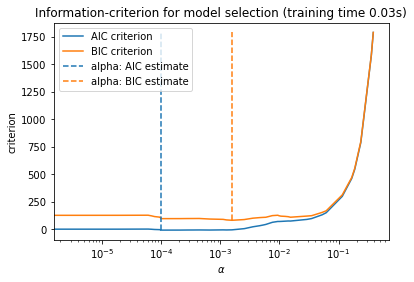

In [13]:
ax = results.plot()
ax.vlines(
    alpha_aic,
    results["AIC criterion"].min(),
    results["AIC criterion"].max(),
    label="alpha: AIC estimate",
    linestyles="--",
    color="tab:blue",
)
ax.vlines(
    alpha_bic,
    results["BIC criterion"].min(),
    results["BIC criterion"].max(),
    label="alpha: BIC estimate",
    linestyle="--",
    color="tab:orange",
)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()
_ = ax.set_title(
    f"Information-criterion for model selection (training time {fit_time:.2f}s)"
)